In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.special
import glob
#import bioinfokit 
from bioinfokit import analys, visuz

pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_columns',85)
pd.set_option('display.max_rows',100)

## What this script does:

    - it loads the pi data and collects all the data in one data frame 
    - it shifts the positions so that everything can be plotted behind each other
    - it normlizes the pi values per window by 
        1. multiplying with the fraction of covered window -> piNorm
        2. additionally, it can also multiply with the fraction of windows that are not nan -> piNormwNaN

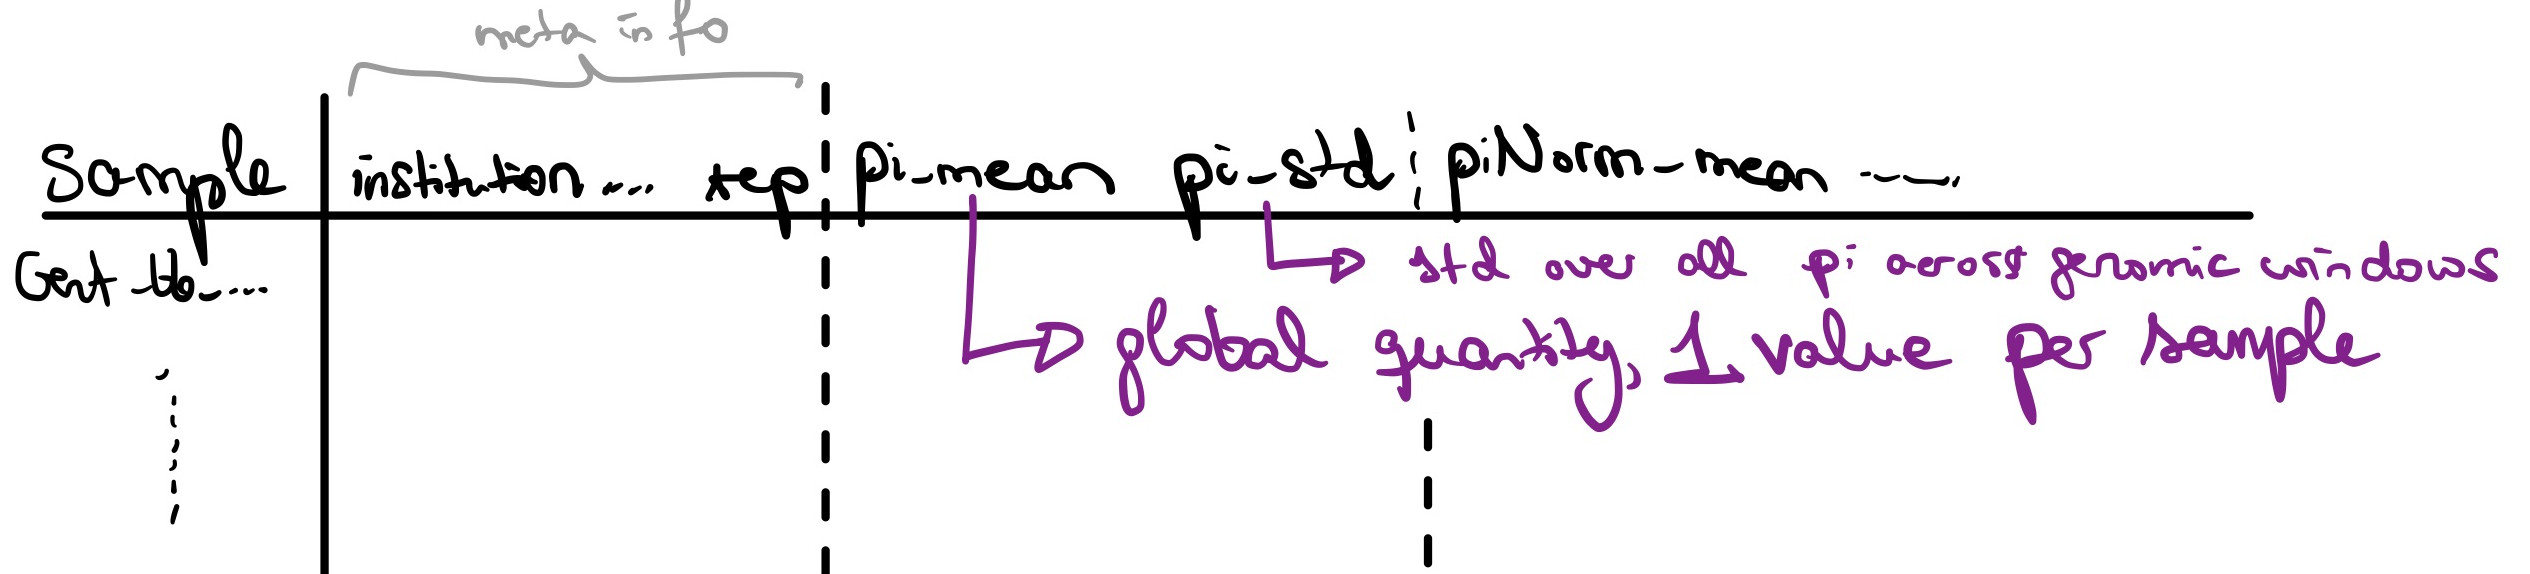

In [3]:
# read in data to panda
# get the number of unclassified reads from Kraken2 outputs

InPath="/home/isabel/Documents/postDoc_Amsterdam/1_EvolWormJourney/1_Genomics/2_EvolGenomics/1_Dev_PipelineCelegans/Pi_Diversity/defaultSet_MultiCov_Pool/"
#files=InPath + "Gent_bb_1_3_Sanger_maxCov500.pi"
files=glob.glob(InPath+"*maxCov800_Pool500.pi")

outPath = "/home/isabel/Documents/postDoc_Amsterdam/1_EvolWormJourney/1_Genomics/2_EvolGenomics/1_Dev_PipelineCelegans/Pi_Diversity/O_output/"

chromosomes=["NC_003279.8","NC_003280.10","NC_003281.10","NC_003282.8","NC_003283.11","NC_003284.9","NC_001328.1"]
chromosomes_end = [1.50750e+07, 3.03500e+07, 4.41350e+07, 6.16300e+07, 8.25550e+07, 1.00270e+08, 1.00285e+08]
#files

In [4]:
## do all the files have the same number of lines and windows?
#(df_2[1].values == df_4[1].values).all()
#len(df_4[1].values)

# define function
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same')/w

In [5]:
samName_collect = []

for i in range(len(files)):
    df_pre = []
    a = files[i].split('/')
    sample=a[-1].split('_')

    sampleName="_".join(sample[0:4])
    samName_collect.append(sampleName)
    #print(sampleName)

    df_pre=pd.read_csv(files[i],header=None, delimiter="\t", index_col=False, na_values="na")
    df_pre.columns=["chr",'window','SNPnum','freq' + "_" + sampleName ,"pi" + "_" + sampleName]
        
    # get the IDs that will be chr name + position
    IDs = list(map(str.__add__, np.array(df_pre['chr'].values, dtype=str), np.array(df_pre['window'].values, dtype=str)))
    df_pre.insert(0, "ID", IDs, True)

    df_pre.set_index("ID",inplace=True)

    ### modify df_pre -- such that it can be plotted in one picture
    ### this only has to be done for the first sample, as the others have unique ID
    
    if i==0: # for the first sample we have to shift the positions
        # start with the first chromosome that doesnt have to be shifted!
        df_shiftRaw = df_pre[df_pre['chr']==chromosomes[0]]
        for j in range(1, len(chromosomes)):
            df_here = df_pre[df_pre['chr']==chromosomes[j]]
            addValue = chromosomes_end[j-1]
            df_here['window'] = df_here['window'].add(addValue)
       
            df_shiftRaw = pd.concat([df_shiftRaw,df_here])
        
    else:
        df_shiftRaw = pd.merge(df_shiftRaw, df_pre[['freq' + "_" + sampleName , "pi" + "_" + sampleName]], on="ID", how="outer")


df_shiftRaw = df_shiftRaw.sort_values(['window'])
df_shiftRaw

,chr,window,SNPnum,freq_VU_bb_0_3,pi_VU_bb_0_3,freq_VU_bn5_0_3,pi_VU_bn5_0_3,freq_UVA_anc_0_1,pi_UVA_anc_0_1,freq_UVA_anc_0_2,pi_UVA_anc_0_2,freq_VU_bb_0_4,pi_VU_bb_0_4,freq_VU_bn50_0_3,pi_VU_bn50_0_3,freq_VU_bn50_0_5,pi_VU_bn50_0_5,freq_VU_bb_0_2,pi_VU_bb_0_2,freq_VU_bn50_0_1,pi_VU_bn50_0_1,freq_VU_bn50_0_4,pi_VU_bn50_0_4,freq_VU_bn50_0_2,pi_VU_bn50_0_2,freq_VU_bn5_0_1,pi_VU_bn5_0_1,freq_VU_bn5_0_2,pi_VU_bn5_0_2,freq_VU_bb_0_5,pi_VU_bb_0_5,freq_UVA_anc_0_3,pi_UVA_anc_0_3,freq_VU_bn5_0_4,pi_VU_bn5_0_4,freq_UVA_bb_0_1,pi_UVA_bb_0_1,freq_VU_bb_0_1,pi_VU_bb_0_1
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NC_003279.85000,NC_003279.8,5000.0,179,0.994,0.002615,0.979,0.002324,0.982,0.002439,0.996,0.002484,0.988,0.002515,0.979,0.002958,0.976,0.002390,0.986,0.002466,1.000,0.002303,0.998,0.002477,0.990,0.002236,0.999,0.002597,0.979,0.001894,1.000,0.002200,1.000,0.002529,0.988,0.002856,0.985,0.002514,0.993,0.002137
NC_003279.815000,NC_003279.8,15000.0,34,0.999,0.000673,1.000,0.000582,1.000,0.000729,0.999,0.000759,0.998,0.000620,0.997,0.000553,0.996,0.000576,0.999,0.000567,1.000,0.000579,0.999,0.000586,0.997,0.000488,0.999,0.000584,0.997,0.000277,0.997,0.000709,0.999,0.000593,0.999,0.000527,0.999,0.000586,0.999,0.000557
NC_003279.825000,NC_003279.8,25000.0,30,0.995,0.000544,0.995,0.000504,0.995,0.000489,1.000,0.000538,0.999,0.000669,0.994,0.000488,0.994,0.000455,0.995,0.000524,0.995,0.000546,1.000,0.000525,0.993,0.000521,0.995,0.000571,0.994,0.000277,0.998,0.000608,0.995,0.000600,0.997,0.000455,0.995,0.000552,0.995,0.000559
NC_003279.835000,NC_003279.8,35000.0,20,0.996,0.000438,0.997,0.000524,0.997,0.000608,0.997,0.000557,0.997,0.000635,0.995,0.000455,0.995,0.000475,0.997,0.000495,0.996,0.000474,0.997,0.000569,0.996,0.000477,0.997,0.000556,0.996,0.000231,0.997,0.000689,0.998,0.000471,0.997,0.000489,0.997,0.000453,0.997,0.000482
NC_003279.845000,NC_003279.8,45000.0,21,1.000,0.000395,1.000,0.000386,1.000,0.000442,0.998,0.000388,0.999,0.000460,0.997,0.000380,0.998,0.000442,1.000,0.000406,1.000,0.000418,1.000,0.000415,0.999,0.000480,1.000,0.000515,0.998,0.000155,1.000,0.000475,1.000,0.000404,1.000,0.000407,1.000,0.000417,1.000,0.000454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC_003284.917695000,NC_003284.9,100250000.0,81,1.000,0.001007,1.000,0.001047,1.000,0.000592,1.000,0.000856,1.000,0.000831,1.000,0.001093,1.000,0.000605,1.000,0.000786,1.000,0.000745,1.000,0.000903,1.000,0.000893,1.000,0.000769,1.000,0.000830,1.000,0.000724,1.000,0.000746,1.000,0.000680,1.000,0.000790,1.000,0.000882
NC_003284.917705000,NC_003284.9,100260000.0,29,1.000,0.000730,1.000,0.000581,1.000,0.000821,1.000,0.000795,1.000,0.000638,1.000,0.000568,1.000,0.000679,1.000,0.000728,1.000,0.000695,1.000,0.000672,1.000,0.000643,1.000,0.000544,1.000,0.000654,1.000,0.000621,1.000,0.000787,1.000,0.000527,1.000,0.000652,1.000,0.000667
NC_003284.917715000,NC_003284.9,100270000.0,48,0.894,0.001386,0.894,0.001108,0.894,0.001594,0.894,0.001489,0.894,0.001301,0.894,0.001104,0.893,0.001133,0.894,0.001185,0.894,0.001245,0.894,0.001147,0.894,0.001238,0.894,0.001020,0.894,0.001285,0.894,0.001138,0.894,0.001229,0.894,0.000991,0.894,0.001246,0.894,0.001312


In [6]:
## now get the df where the pi and freq are multiplied per window
df_shiftNorm = df_shiftRaw[["chr","window"]]
collect_NanNum = np.zeros(len(samName_collect))

## loop over all sample names and add the columns that have the normalized pi value
for i in range(len(samName_collect)):    
    nameHere = samName_collect[i]
    normPi = np.array(df_shiftRaw["freq_" + nameHere].values)*np.array(df_shiftRaw["pi_" + nameHere].values)
    df_shiftNorm["piNorm_" + nameHere] = normPi
    df_shiftNorm

    collect_NanNum[i] = sum(np.isnan(normPi))
df_shiftNorm

,chr,window,piNorm_VU_bb_0_3,piNorm_VU_bn5_0_3,piNorm_UVA_anc_0_1,piNorm_UVA_anc_0_2,piNorm_VU_bb_0_4,piNorm_VU_bn50_0_3,piNorm_VU_bn50_0_5,piNorm_VU_bb_0_2,piNorm_VU_bn50_0_1,piNorm_VU_bn50_0_4,piNorm_VU_bn50_0_2,piNorm_VU_bn5_0_1,piNorm_VU_bn5_0_2,piNorm_VU_bb_0_5,piNorm_UVA_anc_0_3,piNorm_VU_bn5_0_4,piNorm_UVA_bb_0_1,piNorm_VU_bb_0_1
ID,,,,,,,,,,,,,,,,,,,,
NC_003279.85000,NC_003279.8,5000.0,0.002600,0.002275,0.002395,0.002474,0.002485,0.002896,0.002333,0.002432,0.002303,0.002472,0.002214,0.002594,0.001854,0.002200,0.002529,0.002822,0.002477,0.002122
NC_003279.815000,NC_003279.8,15000.0,0.000672,0.000582,0.000729,0.000758,0.000618,0.000551,0.000574,0.000566,0.000579,0.000585,0.000486,0.000583,0.000276,0.000707,0.000592,0.000526,0.000586,0.000556
NC_003279.825000,NC_003279.8,25000.0,0.000541,0.000502,0.000487,0.000538,0.000668,0.000485,0.000452,0.000521,0.000543,0.000525,0.000517,0.000568,0.000276,0.000607,0.000597,0.000454,0.000550,0.000556
NC_003279.835000,NC_003279.8,35000.0,0.000436,0.000522,0.000606,0.000555,0.000633,0.000453,0.000473,0.000494,0.000472,0.000567,0.000475,0.000554,0.000230,0.000687,0.000470,0.000487,0.000452,0.000480
NC_003279.845000,NC_003279.8,45000.0,0.000395,0.000386,0.000442,0.000388,0.000460,0.000379,0.000441,0.000406,0.000418,0.000415,0.000479,0.000515,0.000155,0.000475,0.000404,0.000407,0.000417,0.000454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC_003284.917695000,NC_003284.9,100250000.0,0.001007,0.001047,0.000592,0.000856,0.000831,0.001093,0.000605,0.000786,0.000745,0.000903,0.000893,0.000769,0.000830,0.000724,0.000746,0.000680,0.000790,0.000882
NC_003284.917705000,NC_003284.9,100260000.0,0.000730,0.000581,0.000821,0.000795,0.000638,0.000568,0.000679,0.000728,0.000695,0.000672,0.000643,0.000544,0.000654,0.000621,0.000787,0.000527,0.000652,0.000667
NC_003284.917715000,NC_003284.9,100270000.0,0.001239,0.000991,0.001425,0.001332,0.001163,0.000987,0.001012,0.001060,0.001113,0.001025,0.001106,0.000912,0.001149,0.001018,0.001098,0.000886,0.001114,0.001173


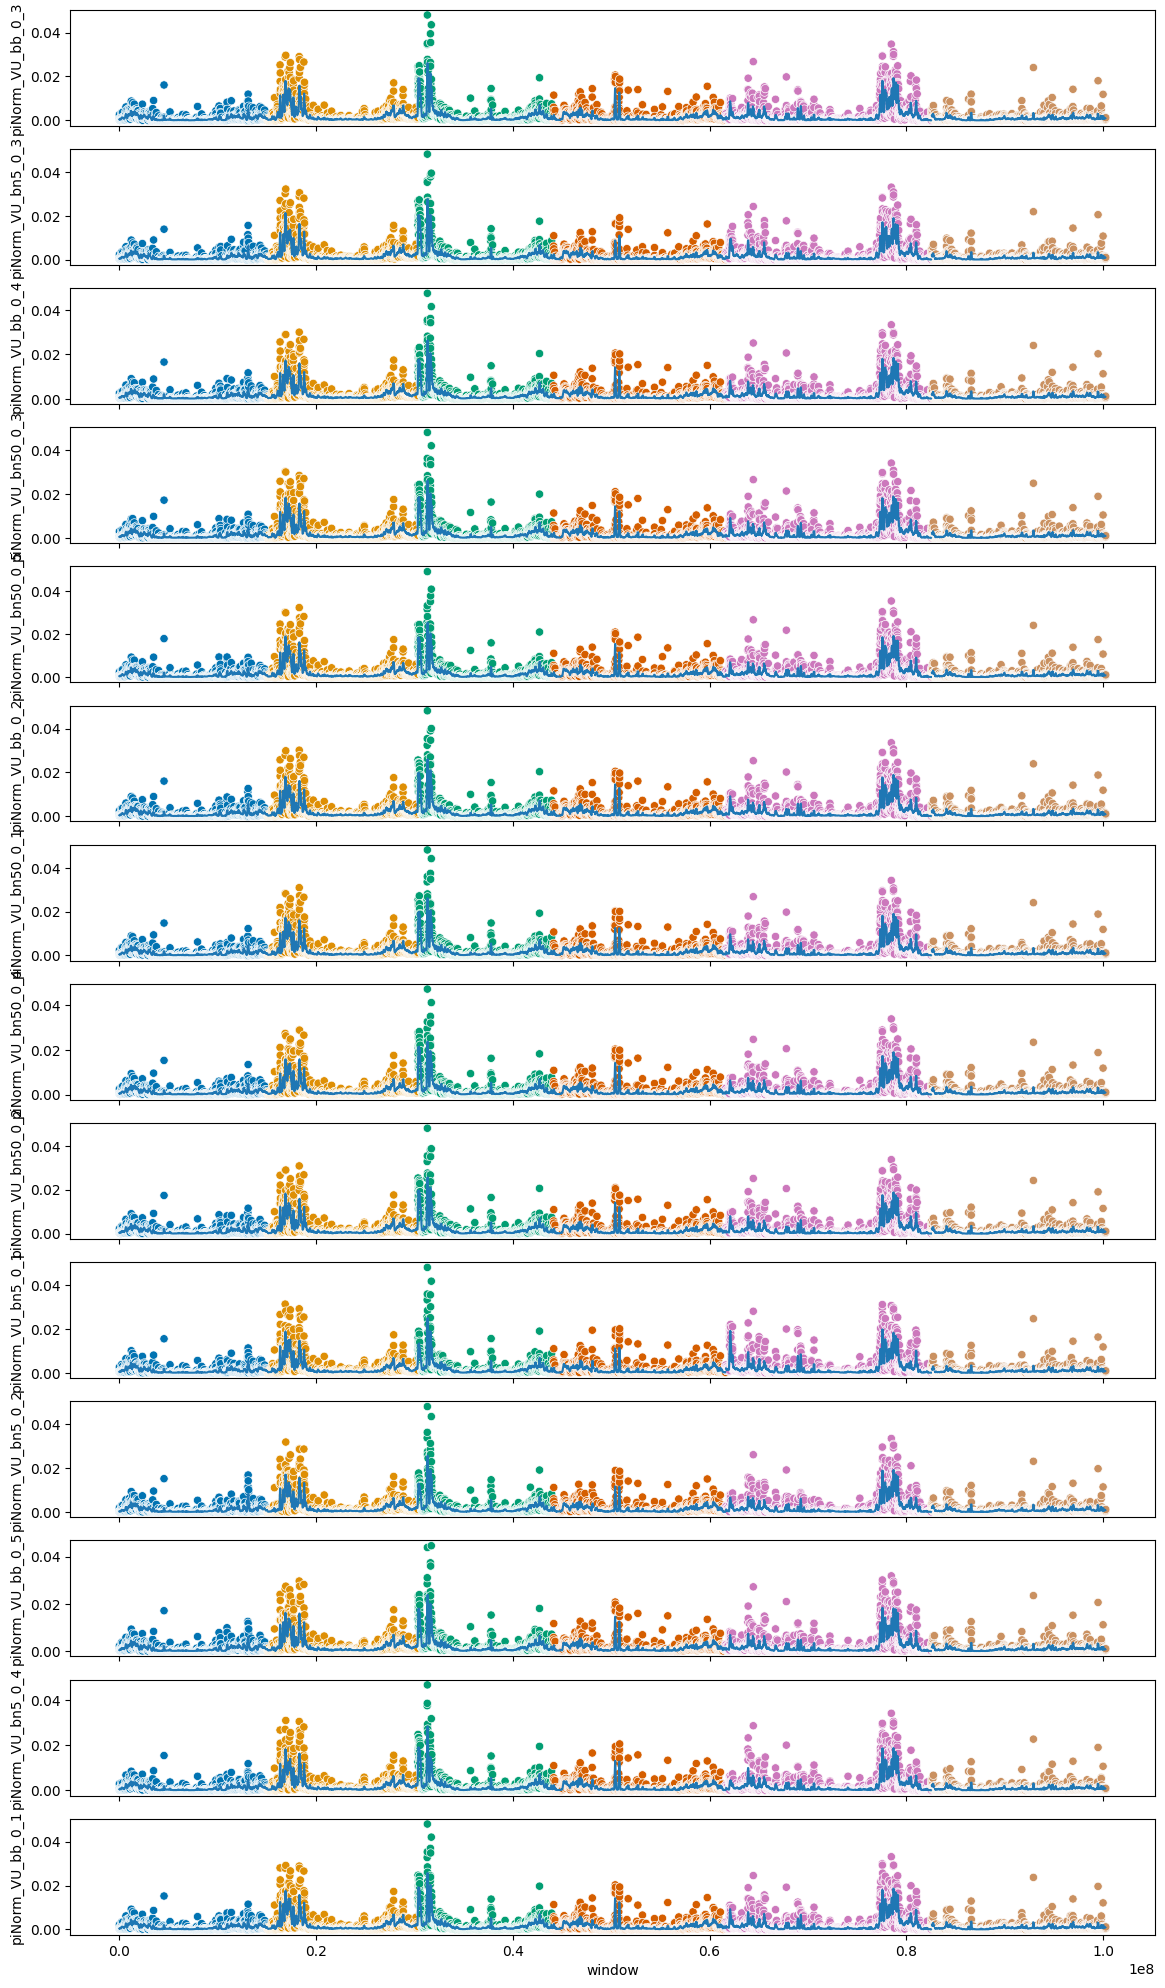

In [6]:
samName_plot = [s for s in samName_collect if "VU" in s]

f1, axx = plt.subplots(len(samName_plot),1, sharex='col', figsize=(14, 25))#, sharex=True)
windowSize=10

for i in range(len(samName_plot)):
    plot = sns.scatterplot(ax=axx[i], data=df_shiftNorm, x='window', y="piNorm"+"_"+samName_plot[i], 
                   hue='chr', palette = 'colorblind', legend=None) 
    movmean = moving_average(df_shiftNorm["piNorm"+"_"+samName_plot[i]], windowSize)
    axx[i].plot(np.array(df_shiftNorm['window'].values),movmean)


In [7]:
## prepare data to get the 
samName_collect_pi = ["pi_"+s for s in samName_collect]
samName_collect_piNorm = ["piNorm_"+s for s in samName_collect]

# get part of the 
df_pi = df_shiftRaw[samName_collect_pi]
df_piNorm = df_shiftNorm[samName_collect_piNorm]


In [8]:
## get stuff for plotting
rowNames = df_pi.mean(0).index.tolist()

institution = []
treatment = []
inst_treat =  []
week = []
rep = []
newRowName = []

for i in rowNames:
    nameList = i.split('_')
    institution.append(nameList[1])
    treatment.append(nameList[2])
    inst_treat.append(nameList[1] + "_" + nameList[2])
    week.append(int(nameList[3]))
    rep.append(nameList[4])

    newRowName.append(nameList[1] + "_" + nameList[2] + "_" + nameList[3] + "_" + nameList[4])


In [9]:
## create the panda data frame
overview = pd.DataFrame(
    {'ID': newRowName,
    'institution': institution,
    'treatment': treatment,
    'inst_treat': inst_treat,
    'week': week,
    'rep': rep,
    'pi_mean': df_pi.mean(0),
    'pi_std': df_pi.std(0),
    'piNorm_mean': df_piNorm.mean(0).values,
    'piNorm_std': df_piNorm.std(0).values,
    'piNormwNaN_mean': df_piNorm.mean(0).values * (1- collect_NanNum/df_shiftRaw.shape[0]),
    'piNormwNaN_std': df_piNorm.std(0).values * (1 - collect_NanNum/df_shiftRaw.shape[0])}
)

overview.set_index(['institution','treatment','inst_treat','week','rep'])
overview.sort_index()
#overview.set_index(['institution','treatment','inst_treat','week','rep'])
# overview['institution'] = overview['institution'].astype(str)
# overview['treatment'] = overview['treatment'].astype(str)
# overview['week'] = overview['week'].astype(str)
# overview['rep'] = overview['rep'].astype(str)

,ID,institution,treatment,inst_treat,week,rep,pi_mean,pi_std,piNorm_mean,piNorm_std,piNormwNaN_mean,piNormwNaN_std
pi_UVA_anc_0_1,UVA_anc_0_1,UVA,anc,UVA_anc,0,1,0.001793,0.003319,0.001783,0.003291,0.001780,0.003287
pi_UVA_anc_0_2,UVA_anc_0_2,UVA,anc,UVA_anc,0,2,0.001774,0.003299,0.001765,0.003274,0.001762,0.003269
pi_UVA_anc_0_3,UVA_anc_0_3,UVA,anc,UVA_anc,0,3,0.001756,0.003264,0.001744,0.003232,0.001742,0.003228
pi_UVA_bb_0_1,UVA_bb_0_1,UVA,bb,UVA_bb,0,1,0.001726,0.003154,0.001713,0.003123,0.001711,0.003119
pi_VU_bb_0_1,VU_bb_0_1,VU,bb,VU_bb,0,1,0.001754,0.003205,0.001741,0.003175,0.001739,0.003171
pi_VU_bb_0_2,VU_bb_0_2,VU,bb,VU_bb,0,2,0.001747,0.003233,0.001736,0.003207,0.001734,0.003204
pi_VU_bb_0_3,VU_bb_0_3,VU,bb,VU_bb,0,3,0.001748,0.003256,0.001737,0.003228,0.001735,0.003224
pi_VU_bb_0_4,VU_bb_0_4,VU,bb,VU_bb,0,4,0.001742,0.003172,0.001731,0.003144,0.001729,0.003140
pi_VU_bb_0_5,VU_bb_0_5,VU,bb,VU_bb,0,5,0.001710,0.003150,0.001694,0.003108,0.001692,0.003104
pi_VU_bn50_0_1,VU_bn50_0_1,VU,bn50,VU_bn50,0,1,0.001722,0.003241,0.001710,0.003210,0.001708,0.003205


In [10]:
# only look at backbone
overviewBB = overview.loc[(overview['treatment']=="bb") | (overview['treatment']=="anc")]
overviewnotBB = overview.loc[(overview['treatment']!="bb") | (overview['treatment']=="anc")]
overviewW0 = overview.loc[(overview['week']==0)]
overviewW1 = overview.loc[(overview['week']==1)]
overviewW15 = overview.loc[(overview['week']==15)]

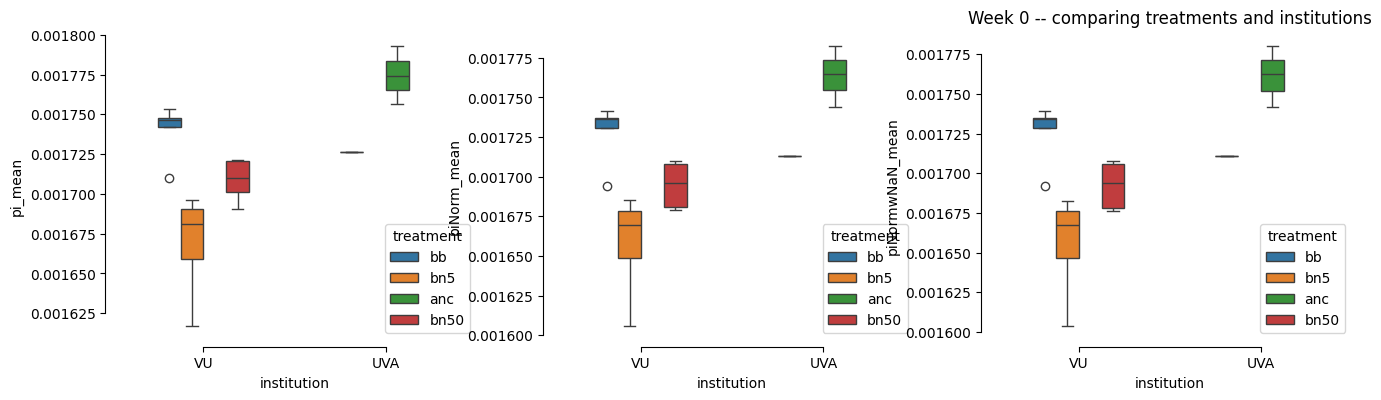

In [11]:
## hypothesis: different treatments start out with different diversity from the start:

fig1, ax1 = plt.subplots(1,3, figsize=(16,4))
plt.title('Week 0 -- comparing treatments and institutions')
sns.boxplot(data=overviewW0, x="institution", y="pi_mean", hue="treatment", width=0.5, ax=ax1[0])
#sns.move_legend(ax1[0], "upper left", bbox_to_anchor=(1, 1))
sns.boxplot(data=overviewW0, x="institution", y="piNorm_mean", hue="treatment", width=0.5, ax=ax1[1])
sns.boxplot(data=overviewW0, x="institution", y="piNormwNaN_mean", hue="treatment", width=0.5, ax=ax1[2])

#sns.move_legend(ax1[1], "upper left", bbox_to_anchor=(1, 1))

sns.despine(offset=5, trim=True)


In [12]:
### save the data:

overview.to_pickle(outPath + "PiDiversity_maxCov800_Pool500.pkl")

In [14]:
###
sns.histplot(data=df_shiftRaw, x="pi"+"_"+samName_collect[0])
sns.histplot(data=df_shiftRaw, x="pi"+"_"+samName_collect[3])

,pi_VU_bb_0_3,pi_VU_bn5_0_3,pi_UVA_anc_0_1,pi_UVA_anc_0_2,pi_VU_bb_0_4,pi_VU_bn50_0_3,pi_VU_bn50_0_5,pi_VU_bb_0_2,pi_VU_bn50_0_1,pi_VU_bn50_0_4,pi_VU_bn50_0_2,pi_VU_bn5_0_1,pi_VU_bn5_0_2,pi_VU_bb_0_5,pi_UVA_anc_0_3,pi_VU_bn5_0_4,pi_UVA_bb_0_1,pi_VU_bb_0_1
ID,,,,,,,,,,,,,,,,,,
NC_003279.85000,0.002615,0.002324,0.002439,0.002484,0.002515,0.002958,0.002390,0.002466,0.002303,0.002477,0.002236,0.002597,0.001894,0.002200,0.002529,0.002856,0.002514,0.002137
NC_003279.815000,0.000673,0.000582,0.000729,0.000759,0.000620,0.000553,0.000576,0.000567,0.000579,0.000586,0.000488,0.000584,0.000277,0.000709,0.000593,0.000527,0.000586,0.000557
NC_003279.825000,0.000544,0.000504,0.000489,0.000538,0.000669,0.000488,0.000455,0.000524,0.000546,0.000525,0.000521,0.000571,0.000277,0.000608,0.000600,0.000455,0.000552,0.000559
NC_003279.835000,0.000438,0.000524,0.000608,0.000557,0.000635,0.000455,0.000475,0.000495,0.000474,0.000569,0.000477,0.000556,0.000231,0.000689,0.000471,0.000489,0.000453,0.000482
NC_003279.845000,0.000395,0.000386,0.000442,0.000388,0.000460,0.000380,0.000442,0.000406,0.000418,0.000415,0.000480,0.000515,0.000155,0.000475,0.000404,0.000407,0.000417,0.000454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC_003284.917695000,0.001007,0.001047,0.000592,0.000856,0.000831,0.001093,0.000605,0.000786,0.000745,0.000903,0.000893,0.000769,0.000830,0.000724,0.000746,0.000680,0.000790,0.000882
NC_003284.917705000,0.000730,0.000581,0.000821,0.000795,0.000638,0.000568,0.000679,0.000728,0.000695,0.000672,0.000643,0.000544,0.000654,0.000621,0.000787,0.000527,0.000652,0.000667
NC_003284.917715000,0.001386,0.001108,0.001594,0.001489,0.001301,0.001104,0.001133,0.001185,0.001245,0.001147,0.001238,0.001020,0.001285,0.001138,0.001229,0.000991,0.001246,0.001312


In [7]:
import Pi_GetData_fcn


ModuleNotFoundError: No module named 'Pi_GetData_fcn'